## Importamos Librerias

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
from deap import base, creator, tools, algorithms

## Cargar datos JSON con los tiempos de procesamiento de reseñas de películas

In [2]:
with open('reviews.json') as f:
    processing_times = json.load(f)  # Lista de tiempos de procesamiento para cada reseña

## Parámetros generales del problema

In [3]:
num_processors = 8                     # Número de procesadores disponibles para distribuir las tareas
window_size = 100                      # Tamaño de las ventanas deslizantes (100 reseñas por ventana)
population_size = 50                   # Tamaño de la población en el algoritmo genético
num_generations = 100                  # Número de generaciones en el algoritmo genético
review_counts = [10000, 20000, 30000,  # Lista con cantidades de reseñas para analizar el rendimiento
                 40000, 50000, 60000,
                 70000, 80000, 90000, 100000]

## Configuración de DEAP para el algoritmo genético
## Se crean las clases necesarias para individuos y fitness

In [4]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Clase para minimizar el tiempo de procesamiento máximo
creator.create("Individual", list, fitness=creator.FitnessMin)  # Clase que representa a un individuo como una lista

## Configuración de operadores del algoritmo genético

In [5]:
toolbox = base.Toolbox()
toolbox.register("attr_processor", random.randint, 0, num_processors - 1)  # Atributo: procesador aleatorio (0 a 7)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_processor, n=window_size)  # Crear un individuo
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Crear una población de individuos

## Función de fitness: calcula el tiempo máximo de procesamiento entre procesadores para un individuo


In [6]:
def fitness(individual, times):
    processor_times = [0] * num_processors  # Inicializa tiempos de los procesadores
    for task_index, processor in enumerate(individual):  # Asigna tareas a procesadores
        processor_times[processor] += times[task_index]  # Suma el tiempo de cada tarea al procesador correspondiente
    return max(processor_times),  # Devuelve el tiempo máximo, ya que es el valor que queremos minimizar

## Registro de la función de fitness y operadores genéticos en el toolbox

In [7]:
toolbox.register("evaluate", fitness)  # Registra la función de evaluación
toolbox.register("mate", tools.cxUniform, indpb=0.5)  # Cruce uniforme con probabilidad de intercambio del 50%
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)  # Mutación: invierte el procesador asignado con probabilidad del 10%
toolbox.register("select", tools.selRoulette)  # Selección por ruleta (probabilidad proporcional al fitness)

## Parámetros para el Sistema Inmunológico Artificial (AIS)

In [8]:
memory_size = 10  # Número de soluciones óptimas (anticuerpos) a mantener en memoria
clone_factor = 5  # Número de clones generados por cada anticuerpo

## Inicialización de la memoria de anticuerpos

In [9]:
antibody_memory = []  # Lista para almacenar las mejores soluciones encontradas

## Función para actualizar la memoria de anticuerpos con una nueva solución

In [10]:
def update_memory(new_individual, window_times):
    new_fitness = fitness(new_individual, window_times)[0]
    # Si la memoria está vacía o la nueva solución es mejor que la peor en la memoria
    if len(antibody_memory) < memory_size or new_fitness < max(fitness(antibody, window_times)[0] for antibody in antibody_memory):
        antibody_memory.append(new_individual)  # Agregar la nueva solución
        antibody_memory.sort(key=lambda ind: fitness(ind, window_times)[0])  # Ordenar por fitness
        if len(antibody_memory) > memory_size:  # Si la memoria excede el tamaño permitido
            antibody_memory.pop()  # Eliminar el peor anticuerpo

## Función para clonar y mutar un anticuerpo, generando diversidad en las soluciones

In [11]:
def clone_and_mutate(antibody):
    clones = []
    for _ in range(clone_factor):  # Generar clones
        clone = toolbox.clone(antibody)  # Crear una copia del anticuerpo
        toolbox.mutate(clone)  # Aplicar mutación al clon
        clones.append(clone)  # Agregar a la lista de clones
    return clones

## Implementación del Algoritmo Genético combinado con AIS

In [12]:
def genetic_algorithm_with_ais(window_times):
    population = toolbox.population(n=population_size)  # Inicializa la población
    for ind in population:  # Evalúa la población inicial
        ind.fitness.values = fitness(ind, window_times)
    
    for gen in range(num_generations):  # Para cada generación
        # Actualizar memoria de anticuerpos con soluciones de la población
        for ind in population:
            if ind.fitness.values < (fitness(antibody_memory[-1], window_times) if antibody_memory else (float('inf'),)):
                update_memory(ind, window_times)
        
        # Generar clones de los anticuerpos y agregarlos a la población
        clones = [clone for antibody in antibody_memory for clone in clone_and_mutate(antibody)]
        population.extend(clones)  # Añadir clones a la población
        
        # Selección, cruce y mutación
        offspring = toolbox.select(population, k=population_size)  # Selección de la siguiente generación
        offspring = list(map(toolbox.clone, offspring))  # Clonar la población seleccionada
        
        for child1, child2 in zip(offspring[::2], offspring[1::2]):  # Aplicar operadores genéticos
            if random.random() < 0.5:  # Probabilidad de cruce
                toolbox.mate(child1, child2)
            toolbox.mutate(child1)  # Aplicar mutación
            toolbox.mutate(child2)
            child1.fitness.values = fitness(child1, window_times)  # Recalcular fitness
            child2.fitness.values = fitness(child2, window_times)
        
        population[:] = offspring  # Reemplazar la población con la nueva generación
    
    best_individual = tools.selBest(population, k=1)[0]  # Seleccionar el mejor individuo
    return best_individual, fitness(best_individual, window_times)[0]  # Retornar el mejor individuo y su fitness

## Análisis de tiempos secuenciales y paralelos optimizados

In [13]:
def analyze_processing_times_with_ais():
    sequential_times = []  # Almacena tiempos secuenciales
    parallel_times = []    # Almacena tiempos paralelos optimizados
    
    for review_count in review_counts:
        # Procesamiento secuencial: suma de todos los tiempos de reseñas
        sequential_time = sum(item["time"] for item in processing_times[:review_count])
        sequential_times.append(sequential_time)
        
        # Procesamiento paralelo optimizado
        total_parallel_time = 0
        for i in range(0, review_count, window_size):  # Dividir en ventanas
            window_times = [item["time"] for item in processing_times[i:i+window_size]]  # Tiempos de la ventana
            _, optimal_time = genetic_algorithm_with_ais(window_times)  # Ejecutar GA+AIS
            total_parallel_time += optimal_time  # Sumar el tiempo paralelo de la ventana
        parallel_times.append(total_parallel_time)
    
        print(f"{review_count} reviews - Sequential: {sequential_time}, Optimized Parallel: {total_parallel_time}")
    
    return sequential_times, parallel_times

## Ejecuta el análisis con AIS y gráfica los resultados

In [14]:
sequential_times, parallel_times = analyze_processing_times_with_ais()

10000 reviews - Sequential: 20.729684591293335, Optimized Parallel: 4.140248775482178
20000 reviews - Sequential: 41.209816455841064, Optimized Parallel: 8.231043338775635
30000 reviews - Sequential: 61.71995258331299, Optimized Parallel: 12.362304449081421
40000 reviews - Sequential: 82.36650466918945, Optimized Parallel: 16.63822340965271
50000 reviews - Sequential: 103.0818510055542, Optimized Parallel: 20.54318141937256
60000 reviews - Sequential: 123.81153559684753, Optimized Parallel: 24.87099289894104
70000 reviews - Sequential: 144.29166746139526, Optimized Parallel: 29.02138113975525
80000 reviews - Sequential: 164.8018035888672, Optimized Parallel: 33.04610753059387
90000 reviews - Sequential: 185.44835567474365, Optimized Parallel: 36.95084810256958
100000 reviews - Sequential: 206.1637020111084, Optimized Parallel: 41.37090611457825


## Graficas

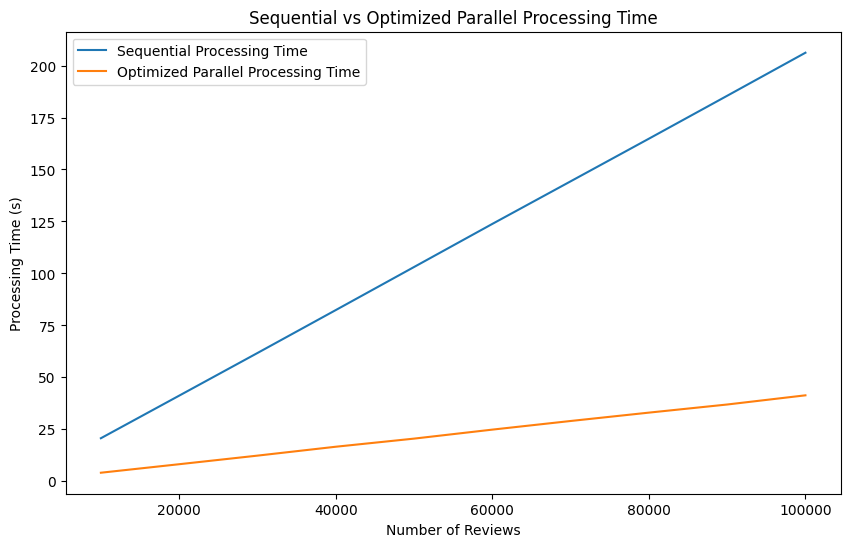

In [15]:
# Gráfico de resultados (líneas)
plt.figure(figsize=(10, 6))
plt.plot(review_counts, sequential_times, label='Sequential Processing Time')
plt.plot(review_counts, parallel_times, label='Optimized Parallel Processing Time')
plt.xlabel('Number of Reviews')
plt.ylabel('Processing Time (s)')
plt.title('Sequential vs Optimized Parallel Processing Time')
plt.legend()
plt.show()

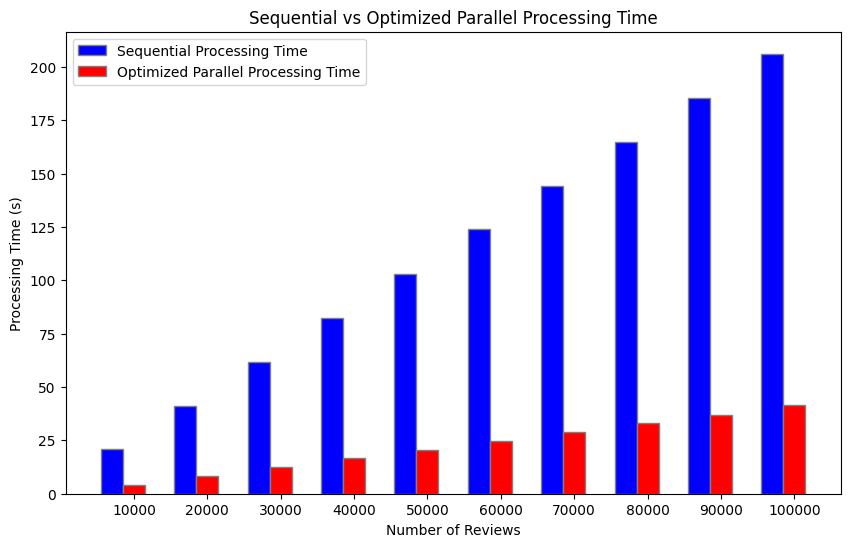

In [16]:
# Gráfico de resultados (barras)
plt.figure(figsize=(10, 6))
barWidth = 0.3
r1 = np.arange(len(review_counts))
r2 = [x + barWidth for x in r1]
plt.bar(r1, sequential_times, color='b', width=barWidth, edgecolor='grey', label='Sequential Processing Time')
plt.bar(r2, parallel_times, color='r', width=barWidth, edgecolor='grey', label='Optimized Parallel Processing Time')
plt.xlabel('Number of Reviews')
plt.ylabel('Processing Time (s)')
plt.title('Sequential vs Optimized Parallel Processing Time')
plt.xticks([r + barWidth for r in range(len(review_counts))], review_counts)
plt.legend()
plt.show()

## Tabla de Resultados

In [17]:
# Tabla de resultados y porcentajes de mejora
speedup = [sequential / parallel for sequential, parallel in zip(sequential_times, parallel_times)]  # Relación de mejora
percent = [(1 - parallel/sequential) * 100 for sequential, parallel in zip(sequential_times, parallel_times)]  # Porcentaje de mejora

# Mostrar tabla de resultados
df = pd.DataFrame({
    'Number of Reviews': review_counts, 
    'Sequential Time': sequential_times, 
    'Parallel Time': parallel_times, 
    'Speedup': speedup, 
    'Improvement (%)': percent
})
df

,Number of Reviews,Sequential Time,Parallel Time,Speedup,Improvement (%)
0,10000,20.729685,4.140249,5.006869,80.027440
1,20000,41.209816,8.231043,5.006633,80.026498
2,30000,61.719953,12.362304,4.992593,79.970327
3,40000,82.366505,16.638223,4.950439,79.799770
4,50000,103.081851,20.543181,5.017813,80.071001
5,60000,123.811536,24.870993,4.978150,79.912217
6,70000,144.291667,29.021381,4.971909,79.887001
7,80000,164.801804,33.046108,4.987026,79.947970
8,90000,185.448356,36.950848,5.018785,80.074858
9,100000,206.163702,41.370906,4.983302,79.932983
